In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ploting.utlis as pltu
import tensorflow as tf


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
def normalize_types(df):
    for column in df.columns[df.dtypes == 'float64']:
        df[column] = df[column].astype(np.float32)

id = 12
X_train = pd.read_csv(f'./data/X_train_{id}.csv', dtype=np.float32).values
X_val = pd.read_csv(f'./data/X_val_{id}.csv', dtype=np.float32).values
X_test = pd.read_csv(f'./data/X_test_{id}.csv', dtype=np.float32).values

# X_train_ae = pickle.load(open(f'./data/x_train_ae_{id}.pkl', 'rb'))
# X_val_ae = pickle.load(open(f'./data/x_val_ae_{id}.pkl', 'rb'))
# X_test_ae = pickle.load(open(f'./data/x_test_ae_{id}.pkl', 'rb'))

y_train = pd.read_csv(f'./data/y_train_{id}.csv', dtype=np.float32).values
y_val = pd.read_csv(f'./data/y_val_{id}.csv', dtype=np.float32).values
y_test = pd.read_csv(f'./data/y_test_{id}.csv', dtype=np.float32).values

ypm_train = pd.read_csv(f'./data/y_train_{id}.csv', dtype=np.float32).values * 1000
ypm_val = pd.read_csv(f'./data/y_val_{id}.csv', dtype=np.float32).values * 1000
ypm_test = pd.read_csv(f'./data/y_test_{id}.csv', dtype=np.float32).values * 1000

ids_train = pd.read_csv(f'./data/ids_train_{id}.csv').values
ids_val = pd.read_csv(f'./data/ids_val_{id}.csv').values
ids_test = pd.read_csv(f'./data/ids_test_{id}.csv').values

buildings_train = pd.read_csv(f'./data/buildings_train_{id}.csv').values
buildings_val = pd.read_csv(f'./data/buildings_val_{id}.csv').values
buildings_test = pd.read_csv(f'./data/buildings_test_{id}.csv').values

print('train', buildings_train.shape, X_train.shape, y_train.shape, ids_train.shape)
print('val', buildings_val.shape, X_val.shape, y_val.shape, ids_val.shape)
print('test', buildings_test.shape, X_test.shape, y_test.shape, ids_test.shape)

train (302, 1) (87990, 1) (87990, 1) (87990, 2)
val (101, 1) (29938, 1) (29938, 1) (29938, 2)
test (101, 1) (28478, 1) (28478, 1) (28478, 2)


In [3]:
id = 1 
buildings_raw = pd.read_csv(f'./data/buildings_{id}.csv')
time_series_raw = pd.read_csv(f'./data/time_series_{id}.csv')

In [4]:
time_step = 14
time_step_out = 3
group = False

In [5]:
def create_sequences(X, y, ids, buildings, time_steps=14, time_steps_out=3, group=False):
    X_output = []
    y_output = []

    for building in buildings:
        if not group and '_grp' in building[0]:
            continue
        
        X_values = X[ids[:,1] == building]
        y_values = y[ids[:,1] == building]

        time_steps_in_hours = time_steps
        _time_steps = time_steps
        _time_steps_out = time_steps_out

        for i in range(len(X_values) - _time_steps + 1):
            if len(y_values) <= (i + _time_steps_out + 1):
                continue
            _X = X_values[i : (i + _time_steps)]
            X_output.append(_X)
            y_output.append(np.sum(y_values[i+1:i+_time_steps_out+1]))

    if(X_output == []):
        return None, None

    return np.stack(X_output), np.array(y_output).reshape(-1, 1)


def create_dataset():
    X_train_seq, y_train_seq = create_sequences(X_train[:], ypm_train[:], ids_train[:], buildings_train[:], time_step, time_step_out, group=group)
    X_val_seq, y_val_seq = create_sequences(X_val[:], ypm_val[:], ids_val[:], buildings_val[:], time_step, time_step_out, group=group)
    X_test_seq, y_test_seq = create_sequences(X_test[:], ypm_test[:], ids_test[:], buildings_test[:], time_step, time_step_out, group=group)

    print('train', X_train_seq.shape, y_train_seq.shape)
    print('val', X_val_seq.shape, y_val_seq.shape)
    print('test', X_test_seq.shape, y_test_seq.shape)

    dataset = {
        'X_train': X_train_seq,
        'X_val': X_val_seq,
        'X_test': X_test_seq,
        'y_train': y_train_seq,
        'y_val': y_val_seq,
        'y_test': y_test_seq,
    }
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
    output_shape = (y_train_seq.shape[1])
    return dataset, input_shape, output_shape

In [6]:
dataset, input_shape, output_shape = create_dataset()

train (84505, 14, 1) (84505, 1)
val (28520, 14, 1) (28520, 1)
test (27112, 14, 1) (27112, 1)


In [7]:
import tensorflow as tf

def max_absolute_error(y_true, y_pred):
    return tf.keras.backend.max(tf.keras.backend.abs(y_true - y_pred))

model = tf.keras.models.load_model('models/lstm_3d_14d_gorup24h_log/r20230918_151116/model.keras',
                           custom_objects={'max_absolute_error': max_absolute_error})

ValueError: Layer 'lstm_cell' expected 3 variables, but received 0 variables during loading. Expected: ['lstm_3/lstm_cell/kernel:0', 'lstm_3/lstm_cell/recurrent_kernel:0', 'lstm_3/lstm_cell/bias:0']

In [ ]:
np.unique( buildings_raw.industry)

array(['Commercial Property', 'Education', 'Government'], dtype=object)

array(['Office_Abigail', 'Office_Abigail', 'Office_Abigail', ...,
       'UnivLab_Priscilla_grp', 'UnivLab_Priscilla_grp',
       'UnivLab_Priscilla_grp'], dtype=object)

In [ ]:
ids_test.shape

(792248, 3)

In [ ]:
dataset['X_test'].shape

(753612, 336, 1)

In [ ]:
X_test_seq, y_test_seq = create_sequences(ylog_test[:], ypm_test[:], ids_test[:], buildings_test[:], time_step, time_step_out, group=group)


In [ ]:
buildings_test_government = buildings_test[np.isin(buildings_test, buildings_raw[buildings_raw.industry == 'Government'].uid.values)]
buildings_test_education = buildings_test[np.isin(buildings_test, buildings_raw[buildings_raw.industry == 'Education'].uid.values)]
buildings_test_commercial_property = buildings_test[np.isin(buildings_test, buildings_raw[buildings_raw.industry == 'Commercial Property'].uid.values)]

In [ ]:
labels = []
metrics = []
i = 0
j = 0
_len = len(buildings_test)
for building in buildings_test:
    i += 1

    if('_grp' in building[0]):
        continue
    X_test_seq, y_test_seq = create_sequences(X_test[:], ypm_test[:], ids_test[:], building, time_step, time_step_out, group=False)
    if(X_test_seq is None):
        continue

    labels.append(building)
    metrics.append(model.evaluate(X_test_seq, y_test_seq, verbose=0))
    j += 1
    print(f'{j}/{i}/{_len}')


1/2/101
2/3/101
3/4/101
4/5/101
5/6/101
6/7/101
7/8/101
8/9/101
9/10/101
10/11/101
11/12/101
12/13/101
13/14/101
14/15/101
15/16/101
16/17/101
17/18/101
18/19/101
19/20/101
20/21/101
21/22/101
22/23/101
23/24/101
24/25/101
25/26/101
26/27/101
27/28/101
28/29/101
29/30/101
30/31/101
31/32/101
32/33/101
33/35/101
34/36/101
35/37/101
36/39/101
37/40/101
38/41/101
39/42/101
40/44/101
41/45/101
42/46/101
43/47/101
44/48/101
45/51/101
46/52/101
47/53/101
48/54/101
49/55/101
50/56/101
51/57/101
52/59/101
53/60/101
54/61/101
55/63/101
56/64/101
57/66/101
58/67/101
59/68/101
60/70/101
61/72/101
62/73/101
63/74/101
64/77/101
65/78/101
66/79/101
67/80/101
68/81/101
69/82/101
70/83/101
71/85/101
72/86/101
73/87/101
74/89/101
75/90/101
76/91/101
77/92/101
78/93/101
79/94/101
80/95/101
81/97/101
82/98/101
83/99/101
84/100/101
85/101/101


In [ ]:
metrics = np.array(metrics)

In [ ]:
 labels = np.array(labels)
 labels = labels.reshape(-1)

In [ ]:
metrics.take(0, axis=1)
data = dict(zip(labels, metrics.take(0, axis=1)))

,timestamp,consumption,uid,temperature,dew_point,humidity,sea_level_pressure,visibility,wind_direction,wind_speed,gust_speed,precipitation,events,conditions,wind_direction_degrees
0,2015-01-01 00:00:00,27.790,Office_Abbey,2.8,-0.6,79.0,1016.0,16.1,WNW,9.3,NaN,NaN,Calm,Mostly Cloudy,300.0
1,2015-01-01 01:00:00,27.660,Office_Abbey,2.8,-0.6,79.0,1016.0,16.1,WNW,9.3,NaN,NaN,Calm,Mostly Cloudy,300.0
2,2015-01-01 02:00:00,27.130,Office_Abbey,2.8,-0.6,79.0,1016.9,16.1,WNW,7.4,NaN,NaN,Calm,Mostly Cloudy,300.0
3,2015-01-01 03:00:00,27.340,Office_Abbey,2.8,-1.1,76.0,1017.2,16.1,NW,5.6,NaN,NaN,Calm,Scattered Clouds,320.0
4,2015-01-01 04:00:00,27.340,Office_Abbey,2.2,-0.6,82.0,1017.5,16.1,ENE,5.6,NaN,NaN,Calm,Partly Cloudy,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881827,2013-12-31 19:00:00,46.250,UnivLab_Tracy,-2.0,-2.0,99.0,1019.0,0.3,NNW,3.7,NaN,NaN,Fog,Heavy Fog,330.0
3881828,2013-12-31 20:00:00,46.000,UnivLab_Tracy,-2.0,-2.0,98.0,1019.0,NaN,North,5.6,NaN,NaN,Calm,NaN,0.0
3881829,2013-12-31 21:00:00,46.500,UnivLab_Tracy,-3.0,-3.0,100.0,1019.0,NaN,NW,3.7,NaN,NaN,Calm,NaN,320.0
3881830,2013-12-31 22:00:00,45.875,UnivLab_Tracy,-3.0,-3.0,100.0,1019.0,0.5,NNE,5.6,NaN,NaN,Fog,Heavy Fog,20.0


In [ ]:
df_metrics = pd.DataFrame(metrics, index=labels, columns=model.metrics_names).sort_values(by='mape', ascending=False)

In [ ]:
consumption_stat = time_series_raw[['uid', 'consumption']].groupby('uid').describe()['consumption']

In [ ]:
time_series_raw.set_index('uid')['consumption']

,timestamp,consumption,temperature,dew_point,humidity,sea_level_pressure,visibility,wind_direction,wind_speed,gust_speed,precipitation,events,conditions,wind_direction_degrees
uid,,,,,,,,,,,,,,
Office_Abbey,2015-01-01 00:00:00,27.790,2.8,-0.6,79.0,1016.0,16.1,WNW,9.3,NaN,NaN,Calm,Mostly Cloudy,300.0
Office_Abbey,2015-01-01 01:00:00,27.660,2.8,-0.6,79.0,1016.0,16.1,WNW,9.3,NaN,NaN,Calm,Mostly Cloudy,300.0
Office_Abbey,2015-01-01 02:00:00,27.130,2.8,-0.6,79.0,1016.9,16.1,WNW,7.4,NaN,NaN,Calm,Mostly Cloudy,300.0
Office_Abbey,2015-01-01 03:00:00,27.340,2.8,-1.1,76.0,1017.2,16.1,NW,5.6,NaN,NaN,Calm,Scattered Clouds,320.0
Office_Abbey,2015-01-01 04:00:00,27.340,2.2,-0.6,82.0,1017.5,16.1,ENE,5.6,NaN,NaN,Calm,Partly Cloudy,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UnivLab_Tracy,2013-12-31 19:00:00,46.250,-2.0,-2.0,99.0,1019.0,0.3,NNW,3.7,NaN,NaN,Fog,Heavy Fog,330.0
UnivLab_Tracy,2013-12-31 20:00:00,46.000,-2.0,-2.0,98.0,1019.0,NaN,North,5.6,NaN,NaN,Calm,NaN,0.0
UnivLab_Tracy,2013-12-31 21:00:00,46.500,-3.0,-3.0,100.0,1019.0,NaN,NW,3.7,NaN,NaN,Calm,NaN,320.0


In [ ]:
df_metrics = df_metrics.join(consumption_stat)

In [ ]:
df_metrics

,loss,mae,mse,mape,max_absolute_error,count,mean,std,min,25%,50%,75%,max
PrimClass_Elisabeth,176.461578,11.186653,176.461578,44.729866,19.946869,8784.0,7.777609,5.633127,1.447217,2.435573,6.929567,12.223550,25.979558
PrimClass_Edwin,96.109261,8.061506,96.109261,20.385502,14.176902,8784.0,4.623429,3.249378,1.447575,2.334083,3.097163,5.617804,14.593633
PrimClass_Eleanor,155.222519,10.444479,155.222519,19.375198,17.997559,8784.0,6.259752,5.004634,1.707000,2.691850,3.764213,8.688294,22.147475
PrimClass_Ethel,98.175873,8.145844,98.175873,17.959938,14.731605,8784.0,6.080766,4.215149,0.158700,2.677967,4.136963,8.475996,19.225775
PrimClass_Janiya,555.083130,16.375595,555.083130,16.226139,34.630379,8760.0,5.206379,5.719018,0.012414,1.900000,2.300000,5.200000,23.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UnivLab_Ashlee,401.134308,16.220100,401.134308,0.782302,28.597626,8760.0,189.596912,13.678494,144.120000,180.340000,187.270000,196.780000,235.800000
UnivDorm_Clayton,26.146103,3.955917,26.146103,0.752070,9.751616,8760.0,68.588023,16.963329,26.049999,52.349998,70.724998,81.074997,117.849998
UnivClass_Alfredo,103.120758,7.829389,103.120758,0.742898,15.175735,8760.0,123.008529,23.899660,53.920000,105.760000,114.835000,139.132500,214.050000
UnivDorm_Alonzo,23.032528,3.771911,23.032528,0.600265,8.814534,8760.0,29.799675,4.579706,17.380000,25.970000,29.660000,32.870000,43.880000


In [ ]:
for group in buildings_raw.groupby('primaryspaceusage'):
    print(group[0], group[1].uid.values)

College Classroom ['UnivClass_Abby' 'UnivClass_Abraham' 'UnivClass_Adrienne'
 'UnivClass_Aidan' 'UnivClass_Alec' 'UnivClass_Alejandra'
 'UnivClass_Alexander' 'UnivClass_Alexandra' 'UnivClass_Alexandria'
 'UnivClass_Alexus' 'UnivClass_Alfredo' 'UnivClass_Alicia'
 'UnivClass_Allen' 'UnivClass_Alvin' 'UnivClass_Amari' 'UnivClass_Amya'
 'UnivClass_Anamaria' 'UnivClass_Andy' 'UnivClass_Anika'
 'UnivClass_Annabella' 'UnivClass_Anne' 'UnivClass_Annmarie'
 'UnivClass_Antoinette' 'UnivClass_Anya' 'UnivClass_Aoibhe'
 'UnivClass_Archie' 'UnivClass_Ariana' 'UnivClass_Armando'
 'UnivClass_Axel' 'UnivClass_Ayanna' 'UnivClass_Beatrice' 'UnivClass_Bob'
 'UnivClass_Boyd' 'UnivClass_Brett' 'UnivClass_Caitlyn' 'UnivClass_Calvin'
 'UnivClass_Camden' 'UnivClass_Candy' 'UnivClass_Caoimhe' 'UnivClass_Carl'
 'UnivClass_Carolyn' 'UnivClass_Cathleen' 'UnivClass_Celia'
 'UnivClass_Chandler' 'UnivClass_Charlie' 'UnivClass_Christian'
 'UnivClass_Ciara' 'UnivClass_Clay' 'UnivClass_Clifford'
 'UnivClass_Colette' 'Un

In [ ]:
model.metrics_names

['loss', 'mae', 'mse', 'mape', 'max_absolute_error']

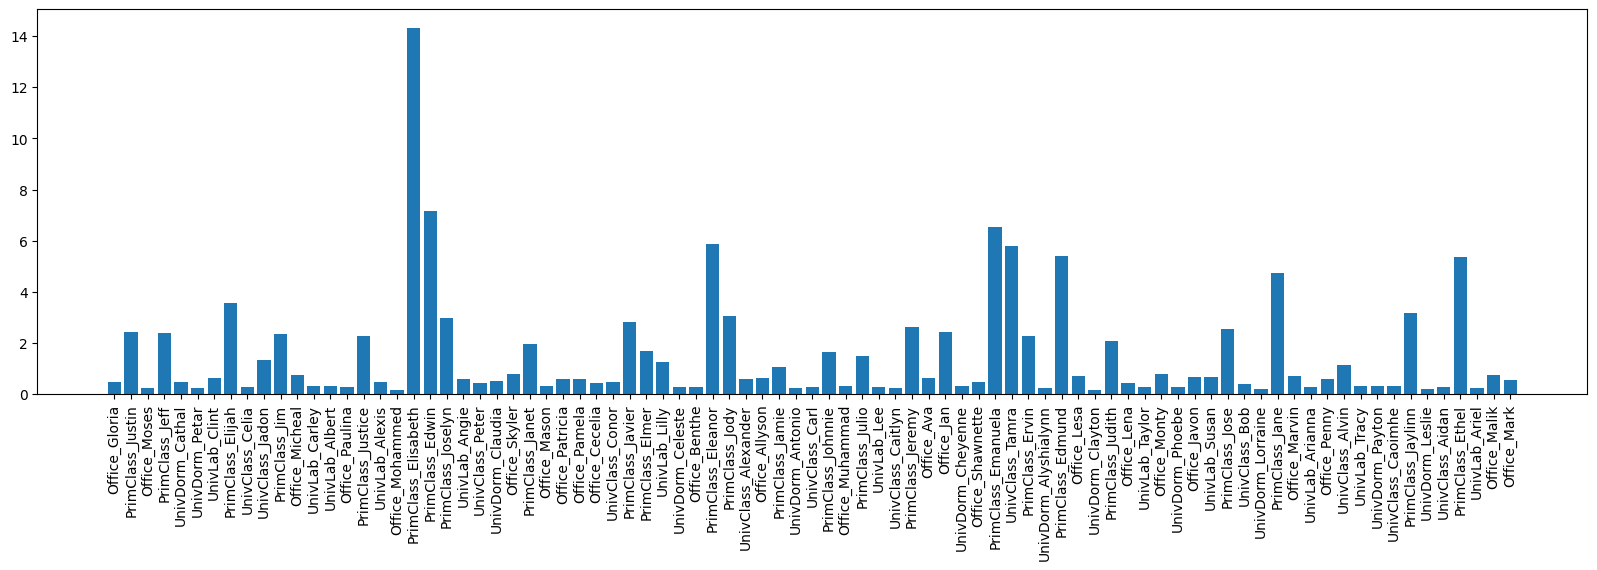

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(labels, metrics.take(3, axis=1), width = 0.8)
plt.xticks(rotation = 90)
plt.show()

,timestamp,consumption,uid,temperature,dew_point,humidity,sea_level_pressure,visibility,wind_direction,wind_speed,gust_speed,precipitation,events,conditions,wind_direction_degrees
1279464,2012-01-01 00:00:00,2.740408,PrimClass_Elisabeth,6.1,2.2,76.0,1019.7,16.1,Calm,0.0,NaN,NaN,Calm,Clear,0.0
1279465,2012-01-01 01:00:00,2.730983,PrimClass_Elisabeth,6.1,2.2,76.0,1019.7,16.1,Calm,0.0,NaN,NaN,Calm,Clear,0.0
1279466,2012-01-01 02:00:00,2.741958,PrimClass_Elisabeth,3.3,1.1,86.0,1020.3,16.1,Calm,0.0,NaN,NaN,Calm,Clear,0.0
1279467,2012-01-01 03:00:00,2.719958,PrimClass_Elisabeth,3.3,1.1,86.0,1020.7,16.1,Calm,0.0,NaN,NaN,Calm,Clear,0.0
1279468,2012-01-01 04:00:00,2.726250,PrimClass_Elisabeth,1.1,-0.6,89.0,1020.3,12.9,Calm,0.0,NaN,NaN,Calm,Clear,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288243,2012-12-31 19:00:00,9.542500,PrimClass_Elisabeth,5.0,-3.9,53.0,1018.1,16.1,SSW,11.1,NaN,NaN,Calm,Overcast,200.0
1288244,2012-12-31 20:00:00,8.175000,PrimClass_Elisabeth,5.0,-3.3,55.0,1017.1,16.1,SW,14.8,NaN,NaN,Calm,Overcast,220.0
1288245,2012-12-31 21:00:00,6.950000,PrimClass_Elisabeth,5.0,-3.3,55.0,1017.1,16.1,SW,14.8,NaN,NaN,Calm,Overcast,220.0
1288246,2012-12-31 22:00:00,6.252500,PrimClass_Elisabeth,6.1,-3.3,51.0,1017.1,16.1,WSW,14.8,NaN,NaN,Calm,Overcast,240.0


In [ ]:
X_test_seq, y_test_seq = create_sequences(ylog_test[:], ypm_test[:], ids_test[:], buildings_test_government[:], time_step, time_step_out, group=False)
model.evaluate(X_test_seq, y_test_seq)

1054/1054 [==============================] - 25s 24ms/step - loss: 682.2882 - mae: 16.2236 - mse: 682.2882 - mape: 5.5946 - max_absolute_error: 35.0180


[682.2882080078125,
 16.223562240600586,
 682.2882080078125,
 5.5946125984191895,
 35.017967224121094]

In [ ]:
X_test_seq, y_test_seq = create_sequences(ylog_test[:], ypm_test[:], ids_test[:], buildings_test_education[:], time_step, time_step_out, group=False)
model.evaluate(X_test_seq, y_test_seq)

21067/21067 [==============================] - 402s 19ms/step - loss: 1125.1147 - mae: 19.4208 - mse: 1125.1147 - mape: 4.7849 - max_absolute_error: 39.1256


[1125.11474609375,
 19.42079734802246,
 1125.11474609375,
 4.784903049468994,
 39.12562942504883]

In [ ]:
buildings_test_education.shape

(96,)

In [ ]:
buildings_test_commercial_property.shape

(2,)

In [ ]:
X_test_seq, y_test_seq = create_sequences(ylog_test[:], ypm_test[:], ids_test[:], buildings_test_commercial_property[:], time_step, time_step_out, group=False)
model.evaluate(X_test_seq, y_test_seq)

529/529 [==============================] - 10s 20ms/step - loss: 23.0196 - mae: 3.7527 - mse: 23.0196 - mape: 2.3743 - max_absolute_error: 9.0846


[23.019601821899414,
 3.7527153491973877,
 23.019601821899414,
 2.3743479251861572,
 9.084559440612793]

In [ ]:
tf.__version__

'2.15.0-dev20230812'

In [ ]:
measures = []
metrics = ['mse', 'mae', 'mape']

for metric in metrics:
    measures.append({
            'metric': metric,
            'set': 'train',
            'column_name': f'train_{metric}'
        })

for metric in metrics:
    measures.append({
            'metric': f'val_{metric}',
            'set': 'val',
            'column_name': f'val_{metric}'
        })
        

In [ ]:
import json

units = [2, 4, 8, 16, 32, 64, 128, 256]
all_history = []
for unit in units:
    for attempt in range(5):
        with open(f'./3_training_2_models/model-{unit}-{attempt}/history.json') as history_file:
            all_history.append({
                'units': unit,
                'attempt': attempt + 1,
                'history': json.load(history_file)
            })

In [ ]:
all_history_columns_for_df = ['units', 'attempt', 'epochs']
metric_columns = []
for measure in measures:
    metric_columns.append(measure['column_name'])
    all_history_columns_for_df.append(measure['column_name'])
for metric in metrics:
    metric_columns.append(f'test_{metric}')
    all_history_columns_for_df.append(f'test_{metric}')

all_history_for_df = []
for history in all_history:
    epochs = len(history['history']['train']['loss'])

    item = [
        history['units'],
        history['attempt'],
        epochs
    ]
    
    for measure in measures:
        metric_value = history['history']['train'][measure['metric']][-1]
        item.append(metric_value)
    
    for index, metric in enumerate(metrics):
        metric_value = history['history']['test'][index]
        item.append(metric_value)

    all_history_for_df.append(item)

all_history_df = pd.DataFrame(all_history_for_df, columns=all_history_columns_for_df)
all_history_df

,units,attempt,epochs,train_mse,train_mae,train_mape,val_mse,val_mae,val_mape,test_mse,test_mae,test_mape
0,2,1,15,3398.317627,37.817108,199.908096,3224.522461,35.531288,247.606293,3237.802490,36.366409,244.414841
1,2,2,15,3361.331787,37.498222,194.880081,3098.323975,34.175861,227.176712,3050.059814,36.421425,335.353485
2,2,3,15,3407.772217,37.908745,194.348328,3196.919189,35.422531,290.066864,3005.608887,36.582745,349.255707
3,2,4,15,3509.637207,38.662621,198.328323,3282.081055,35.838512,274.743866,3321.694092,37.652287,329.900909
4,2,5,15,3527.628174,39.491737,216.353104,3345.813232,35.967152,234.612473,3489.865723,37.367634,296.699799
5,4,1,15,3467.020020,38.159172,200.458176,3278.764648,35.813164,246.363327,3325.294922,38.139591,362.754150
6,4,2,15,3518.657471,38.883064,211.046783,3262.622314,35.982174,241.708450,3336.365234,37.340733,307.393494
7,4,3,15,3549.439697,39.236221,232.204605,3205.203369,34.852089,226.478302,3117.217285,36.782562,286.788910
8,4,4,15,3734.054932,41.170918,264.026337,3551.959473,38.146671,222.051987,3552.830322,40.259842,236.198898
9,4,5,15,3459.405273,38.538475,205.502853,3355.039551,35.758373,188.556152,3425.630859,36.738297,244.547729


In [ ]:
metrics_y_labels = {
    'mse': 'Mean Squared Error',
    'mae': 'Mean Absolute Error',
    'mape': 'Mean Absolute Percentage Error'
}
metrics_title = {
    'mse': 'mean squared error',
    'mae': 'mean absolute error',
    'mape': 'mean absolute percentage error'
}
title_sets_names = {
    'train': 'training',
    'val': 'validation',
    'test': 'test',
}
stats_names = {
    'min': 'minimum',
    'mean': 'mean',
    'max': 'maximum',
    'iqr': 'interquartile range'
}

def draw_box_plot(set, metric):
    plt.figure(figsize=(12, 8))
    all_history_df.boxplot(column=f'{set}_{metric}', by='units', grid=False, figsize=(10,6), fontsize=14, showfliers=True)

    title_set = ''
    plt.title(f'Comparison of {metrics_title[metric]} after 15 epochs (5 attempts)\non the {title_sets_names[set]} set for models with different number of LSTM cells', fontsize=14, fontweight='bold')
    plt.suptitle('')
    plt.ylabel(metrics_y_labels[metric], fontsize=14)
    plt.xlabel('Number of cells in LSTM layer', fontsize=14)
    plt.ylim(metrics_y_lims[metric])
    plt.show()

<Figure size 864x576 with 0 Axes>

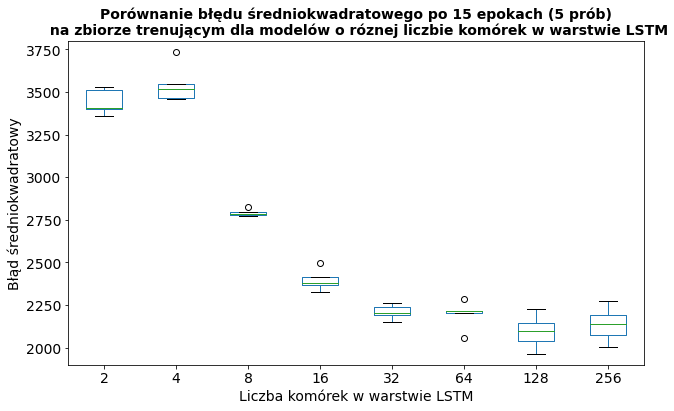

<Figure size 864x576 with 0 Axes>

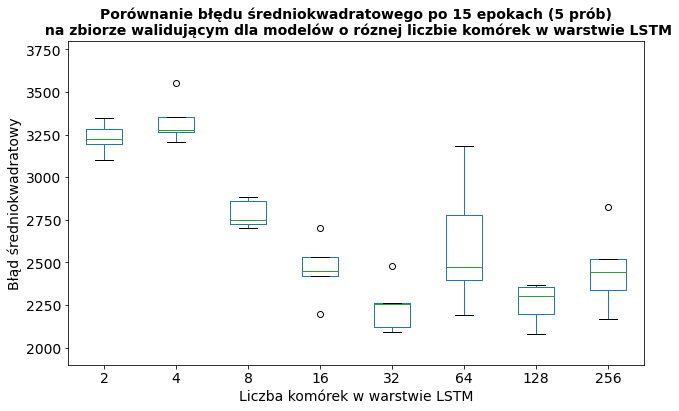

<Figure size 864x576 with 0 Axes>

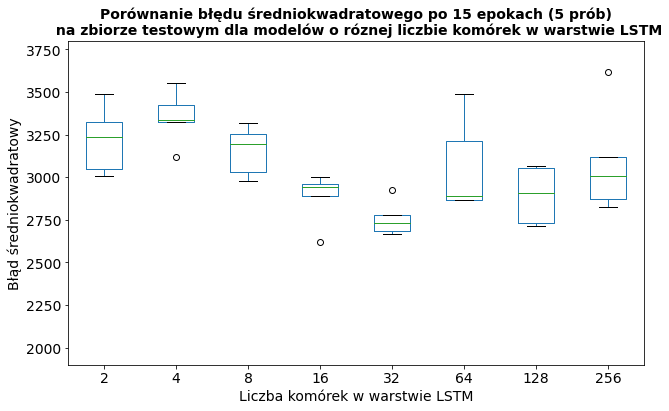

<Figure size 864x576 with 0 Axes>

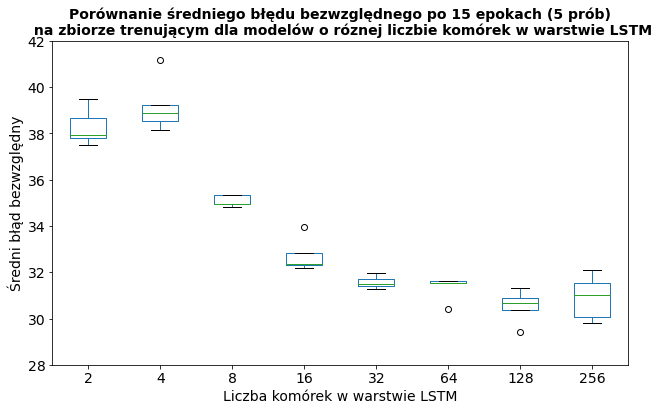

<Figure size 864x576 with 0 Axes>

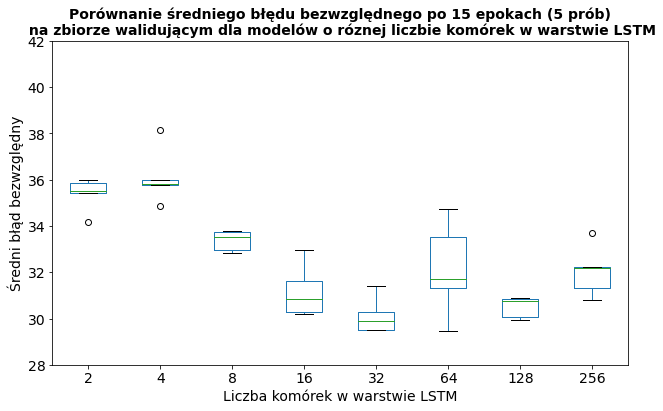

<Figure size 864x576 with 0 Axes>

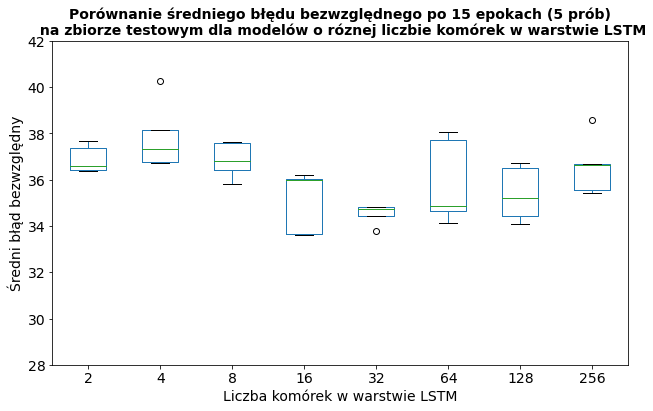

In [ ]:
for metric in ['mse', 'mae']:
    for set in ['train', 'val', 'test']:
        draw_box_plot(set, metric)

In [ ]:
def iqr(series):
      return series.quantile(0.75) - series.quantile(0.25)

agg_mapping = {}
for metric_column in metric_columns:
    agg_mapping[metric_column] = ['min', 'max', 'mean', iqr]
all_history_df_grouped = all_history_df.groupby('units').agg(agg_mapping)
all_history_df_grouped.columns = ["_".join(x) for x in all_history_df_grouped.columns]
all_history_df_grouped = all_history_df_grouped.reset_index()

# for metric in ['mse', 'mae', 'mape']:
#         for stat in ['min', 'max', 'mean']:
#             all_history_df_grouped[f'test_{metric}_{stat}_diff'] = all_history_df_grouped[f'test_{metric}_{stat}'] - all_history_df_grouped[f'train_{metric}_{stat}']

all_history_df_grouped


,units,train_mse_min,train_mse_max,train_mse_mean,train_mse_iqr,train_mae_min,train_mae_max,train_mae_mean,train_mae_iqr,train_mape_min,...,test_mse_mean,test_mse_iqr,test_mae_min,test_mae_max,test_mae_mean,test_mae_iqr,test_mape_min,test_mape_max,test_mape_mean,test_mape_iqr
0,2,3361.331787,3527.628174,3440.937402,111.319580,37.498222,39.491737,38.275687,0.845512,194.348328,...,3221.006201,271.634277,36.366409,37.652287,36.878100,0.946209,244.414841,349.255707,311.124948,38.653687
1,4,3459.405273,3734.054932,3545.715479,82.419678,38.159172,41.170918,39.197570,0.697746,200.458176,...,3351.467725,100.335938,36.738297,40.259842,37.852205,1.357029,236.198898,362.754150,287.536636,62.845764
2,8,2772.735352,2825.238770,2791.352930,12.935791,34.829151,35.356728,35.091492,0.402828,201.961777,...,3154.900342,220.230957,35.824383,37.627716,36.847559,1.170753,243.688446,306.913239,280.877496,36.564026
3,16,2327.615479,2499.833740,2398.912402,48.917236,32.184471,33.958187,32.732196,0.505779,182.823044,...,2882.565332,67.030762,33.606834,36.200905,35.094348,2.361031,195.583755,299.401550,244.612814,29.203979
4,32,2151.552979,2264.765381,2210.322217,50.164062,31.257780,31.956932,31.558523,0.298979,191.028885,...,2756.926270,94.367432,33.789364,34.828213,34.513832,0.382118,231.408096,295.445648,264.121375,44.079239
5,64,2055.775879,2287.385498,2195.706055,10.985107,30.393009,31.609358,31.335809,0.082130,186.560364,...,3064.573682,346.830078,34.139439,38.065041,35.887552,3.042431,216.871826,323.789764,257.252664,37.327621
6,128,1962.244263,2226.841797,2094.478589,106.931885,29.402014,31.333178,30.531264,0.522867,176.737381,...,2894.297314,324.205811,34.102146,36.733276,35.394240,2.082962,239.126022,291.405945,264.729837,9.887756
7,256,2003.971924,2273.743652,2136.715430,121.151123,29.812294,32.083237,30.903423,1.479258,181.933426,...,3088.753809,247.949951,35.424938,38.574490,36.578978,1.133987,235.268951,349.017212,278.926007,33.408569


In [ ]:
metrics_lims = {
    'mse': {
        'min': 3800,
        'mean': 3800,
        'max': 3800,
        'iqr': 400,
    },
    'mae': {
        'min': 42,
        'mean': 42,
        'max': 42,
        'iqr': 3.5,
    },
    'mape': {
        'min': 100,
        'mean': 100,
        'max': 100,
        'iqr': 100,
    },
}

def draw_barh(measure: str):
    sorted = all_history_df_grouped[['units', measure]].sort_values(measure, ascending=False)

    set, metric, stat = measure.split('_')[:3]

    plt.figure(figsize=(10,6))
    plt.barh(range(len(sorted['units'])), sorted[measure])
    plt.yticks(range(len(sorted['units'])), [unit for unit in sorted['units']], fontsize=14)
    plt.ylabel('Number of cells in LSTM layer', fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel(metrics_y_labels[metric], fontsize=14)
    plt.title(f'Comparison of {stats_names[stat]} {metrics_title[metric]} values\nof models obtained for the test set', fontsize=14, fontweight='bold')
    plt.xlim((0, metrics_lims[metric][stat] * 1.1))

    for i, v in enumerate(sorted[measure]):
        text = str(round(v, 2)).replace('.', ',')
        plt.annotate(f'{text}', (v, i), textcoords="offset points", va='center', fontsize=14, xytext=(5,0))

    plt.show()

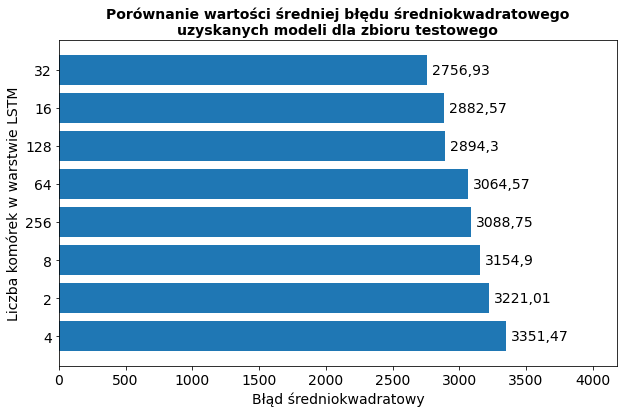

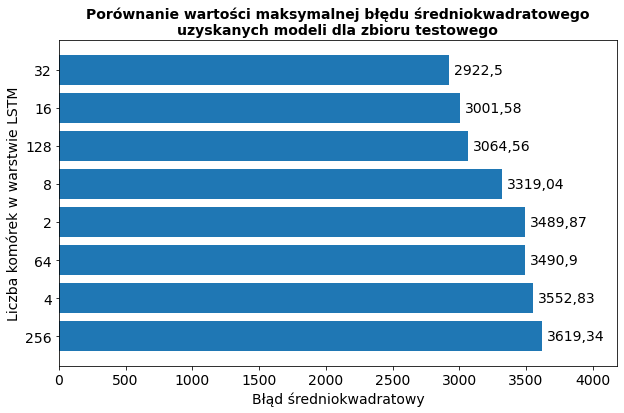

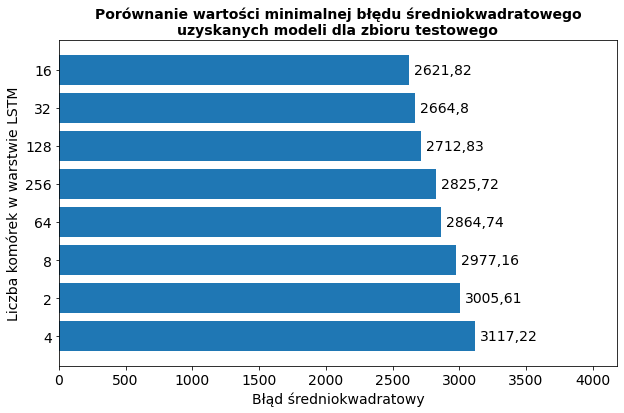

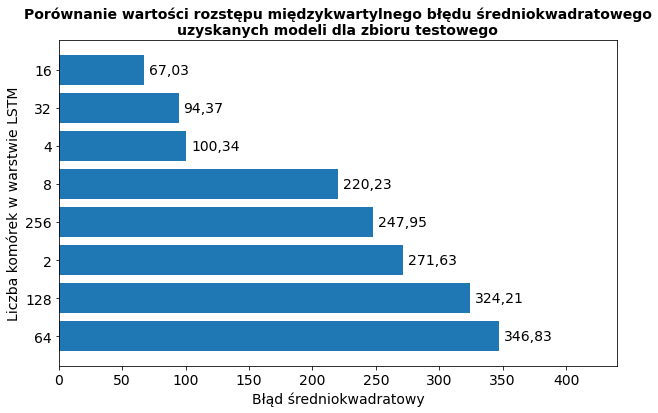

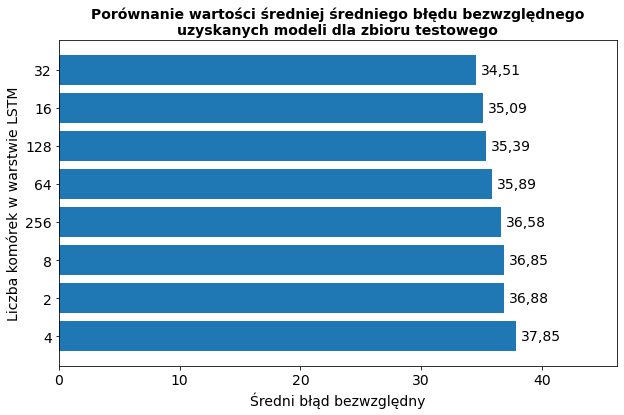

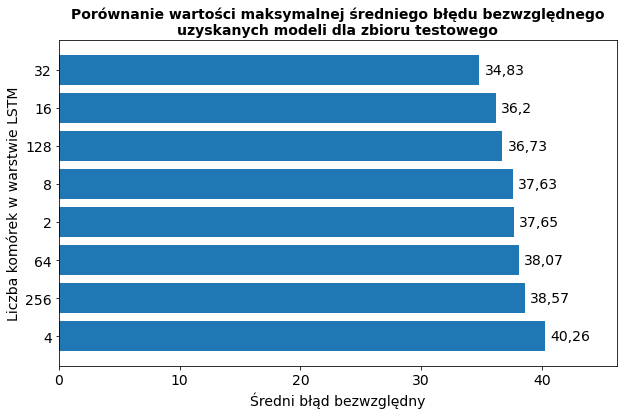

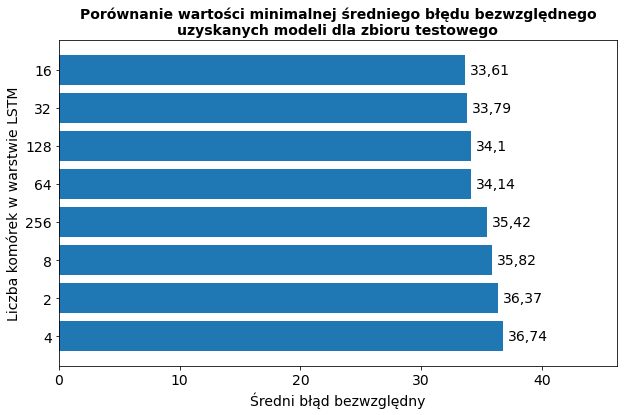

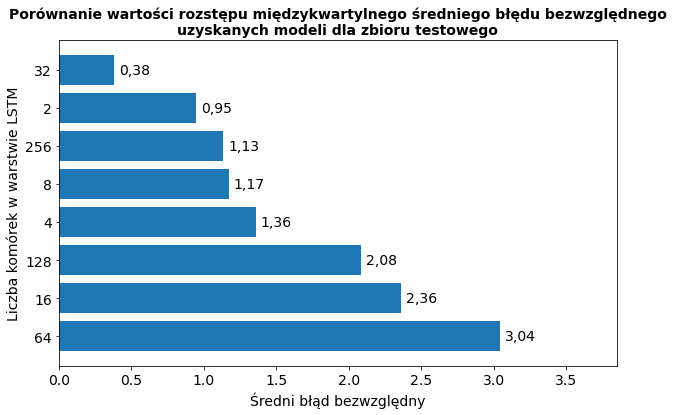

In [ ]:
for metric in ['mse', 'mae']:
    for stat in ['mean', 'max', 'min', 'iqr']:
        draw_barh(f'test_{metric}_{stat}')